<a href="https://colab.research.google.com/github/moonryul/course-nlp/blob/master/Copy_of_RNNFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pylab inline
import math
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [ ]:
sin_wave = np.array( [math.sin(x) for x in np.arange(200)])

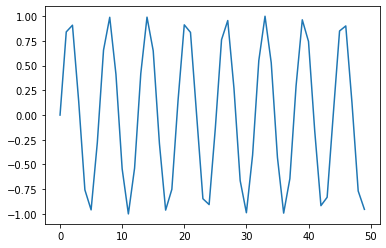

In [ ]:
plt.plot( sin_wave[:50])

In [ ]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    print("X[{0}]={1}".format(i,sin_wave[i:i+seq_len]) )
    print("Y[{0}]={1}".format(i,sin_wave[i+seq_len]) )
    

In [ ]:
num_records

150

In [ ]:
X = np.array(X)
X.shape

(100, 50)

In [ ]:
X = np.expand_dims(X, axis=2)
X.shape

(100, 50, 1)

In [ ]:
Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [ ]:
Y.shape

(100, 1)

In [ ]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

In [ ]:
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # length of sequence
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [ ]:
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [ ]:
U.shape

(100, 50)

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]): # Y.shape[0] = Batch dim
        x, y = X[i], Y[i]                    # get input, output values of each record
        #print("x.shape=", x.shape)
        #print("y.shape=", y.shape)
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    #x.shape = (50, 1):  we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep for the current batch
            mulu = np.dot(U, new_input)      # new_input is a vector where only one place has a non-zero value
            #print("new_input.shape=", new_input.shape)
            #print("mulu.shape=", mulu.shape)
            #print("At t = {0}: new_input={1}".format(t, new_input) )
            #print("mulu=", mulu)
            mulw = np.dot(W, prev_s) # mulu is a 100x1 matrix
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s
    # for i in range(Y.shape[0]): # Y.shape[0] = Batch dim
    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])    

In [ ]:
# check loss on val
val_loss = 0.0
for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
val_loss = val_loss / float(y.shape[0])

print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)

Epoch:  25 , Loss:  [[116709.64788441]] , Val Loss:  [[58352.92078119]]


In [ ]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    
# train model
    for i in range(Y.shape[0]): # for each mini-batch

        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        

        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t] # one-hot input vector for each time step
            mulu = np.dot(U, new_input)

            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})

            prev_s = s
        #for t in range(T):  


        # calculate error for the last output mulv
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    
   
        # derivative of pred for the current mini-batch
        dmulv = (mulv - y)
        
        # backward pass for the current mini-batch
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))

            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)

            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])

                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
            #for i in range(t-1, max(-1, t-bptt_truncate-1), -1):

            dV += dV_t
            dU += dU_t
            dW += dW_t

            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update param for the current mini-batch
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

    

    # for i in range(Y.shape[0]): # Y.shape[0] = Batch dim

    loss = loss / float(y.shape[0])    

    print('Epoch: ', epoch + 1, ', Loss: ', loss)

#for epoch in range(nepoch):    

Epoch:  1 , Loss:  [[94433.57788251]]
Epoch:  2 , Loss:  [[56075.2514908]]
Epoch:  3 , Loss:  [[27716.92396292]]
Epoch:  4 , Loss:  [[9349.09369537]]
Epoch:  5 , Loss:  [[851.79653636]]
Epoch:  6 , Loss:  [[30.26634222]]
Epoch:  7 , Loss:  [[27.58141065]]
Epoch:  8 , Loss:  [[27.60473782]]
Epoch:  9 , Loss:  [[27.67892975]]
Epoch:  10 , Loss:  [[27.52001335]]
Epoch:  11 , Loss:  [[28.17280411]]
Epoch:  12 , Loss:  [[27.81414302]]
Epoch:  13 , Loss:  [[27.35363774]]
Epoch:  14 , Loss:  [[27.73624256]]
Epoch:  15 , Loss:  [[27.75643899]]
Epoch:  16 , Loss:  [[27.91027388]]
Epoch:  17 , Loss:  [[27.29978006]]
Epoch:  18 , Loss:  [[27.6337583]]
Epoch:  19 , Loss:  [[27.79043967]]
Epoch:  20 , Loss:  [[27.96931462]]
Epoch:  21 , Loss:  [[27.91412089]]
Epoch:  22 , Loss:  [[28.13702661]]
Epoch:  23 , Loss:  [[27.59571769]]
Epoch:  24 , Loss:  [[27.74156722]]
Epoch:  25 , Loss:  [[27.82615383]]


In [ ]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

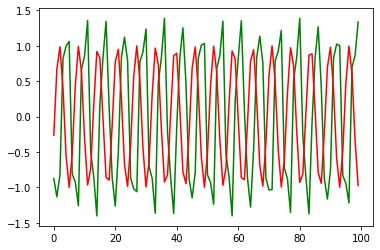

In [ ]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()